Lambda School Data Science

*Unit 2, Sprint 3, Module 3*

---

# Applied Modeling, Module 3

- Visualize and interpret **partial dependence plots**

### Links
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)



### Three types of model explanations this unit:

#### 1. Global model explanation: all features in relation to each other _(Yesterday)_
- Feature Importances: _Default, fastest, good for first estimates_
- Drop-Column Importances: _The best in theory, but much too slow in practice_
- Permutaton Importances: _A good compromise!_

#### 2. Global model explanation: individual feature(s) in relation to target _(Today)_
- Partial Dependence plots

#### 3. Individual prediction explanation _(Tomorrow)_
- Shapley Values

_Note that the coefficients from a linear model give you all three types of explanations!_

### Setup

You can work locally (follow the [local setup instructions](https://lambdaschool.github.io/ds/unit2/local/)) or on Colab (run the code cell below).


In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Applied-Modeling.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

In [2]:
# Ignore this warning: https://github.com/dmlc/xgboost/issues/4300
# xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='xgboost')

## Lending Club: Predict interest rate

In [3]:
import pandas as pd

# Stratified sample, 10% of expired Lending Club loans, grades A-D
# Source: https://www.lendingclub.com/info/download-data.action
history_location = '../data/lending-club/lending-club-subset.csv'
history = pd.read_csv(history_location)
history['issue_d'] = pd.to_datetime(history['issue_d'], infer_datetime_format=True)

# Just use 36 month loans
history = history[history.term==' 36 months']

# Index & sort by issue date
history = history.set_index('issue_d').sort_index()

# Clean data, engineer feature, & select subset of features
history = history.rename(columns=                     
    {'annual_inc': 'Annual Income', 
     'fico_range_high': 'Credit Score', 
     'funded_amnt': 'Loan Amount', 
     'title': 'Loan Purpose'})

history['Interest Rate'] = history['int_rate'].str.strip('%').astype(float)
history['Monthly Debts'] = history['Annual Income'] / 12 * history['dti'] / 100

columns = ['Annual Income', 
           'Credit Score', 
           'Loan Amount', 
           'Loan Purpose', 
           'Monthly Debts', 
           'Interest Rate']

history = history[columns]
history = history.dropna()

# Test on the last 10,000 loans,
# Validate on the 10,000 before that,
# Train on the rest
test = history[-10000:]
val = history[-20000:-10000]
train = history[:-20000]

In [4]:
# Assign to X, y
target = 'Interest Rate'
features = history.columns.drop('Interest Rate')

X_train = train[features]
y_train = train[target]

X_val = val[features]
y_val = val[target]

X_test = test[features]
y_test = test[target]

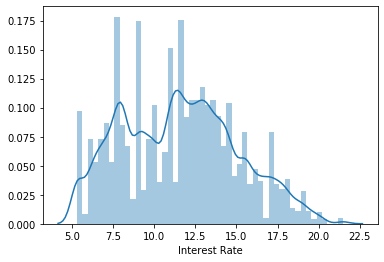

In [5]:
# The target has some right skew, but it's not too bad
%matplotlib inline
import seaborn as sns
sns.distplot(y_train);

### Fit Linear Regression model

In [6]:
import category_encoders as ce
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

lr = make_pipeline(
    ce.OrdinalEncoder(), # Not ideal for Linear Regression 
    StandardScaler(), 
    LinearRegression()
)

lr.fit(X_train, y_train)
print('Linear Regression R^2', lr.score(X_val, y_val))

Linear Regression R^2 0.21454894710371264


### Fit Gradient Boosting model

In [7]:
from sklearn.metrics import r2_score
from xgboost import XGBRegressor

gb = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBRegressor(n_estimators=200, objective='reg:squarederror', n_jobs=-1)
)

gb.fit(X_train, y_train)
y_pred = gb.predict(X_val)
print('Gradient Boosting R^2', r2_score(y_val, y_pred))

Gradient Boosting R^2 0.27488377264062747


### Explaining Linear Regression

In [8]:
example = X_val.iloc[[0]]
example

Annual Income  Credit Score  Loan Amount             Loan Purpose  \
issue_d                                                                         
2016-12-01        68700.0         729.0       7150.0  Credit card refinancing   

            Monthly Debts  
issue_d                    
2016-12-01      1452.4325

In [9]:
pred = lr.predict(example)[0]
print(f'Predicted Interest Rate: {pred:.2f}%')

Predicted Interest Rate: 9.96%


In [10]:
import numpy as np

def vary_income(model, example):
    print('Vary income, hold other features constant', '\n')
    example = example.copy()
    preds = []
    for income in range(20000, 200000, 20000):
        example['Annual Income'] = income
        pred = model.predict(example)[0]
        print(f'Predicted Interest Rate: {pred:.3f}%')
        print(example.to_string(), '\n')
        preds.append(pred)
    print('Difference between predictions')
    print(np.diff(preds))
        
vary_income(lr, example)

Vary income, hold other features constant 

Predicted Interest Rate: 10.117%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 10.052%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 9.987%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Inter

In [11]:
example2 = X_val.iloc[[2]]
vary_income(lr, example2)

Vary income, hold other features constant 

Predicted Interest Rate: 12.513%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 12.448%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 12.383%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Inte

### Explaining Gradient Boosting???

In [12]:
vary_income(gb, example)

Vary income, hold other features constant 

Predicted Interest Rate: 10.264%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 10.928%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Interest Rate: 9.037%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         729.0       7150.0  Credit card refinancing      1452.4325 

Predicted Inter

In [13]:
vary_income(gb, example2)

Vary income, hold other features constant 

Predicted Interest Rate: 12.600%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          20000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 13.156%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          40000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Interest Rate: 11.596%
            Annual Income  Credit Score  Loan Amount             Loan Purpose  Monthly Debts
issue_d                                                                                     
2016-12-01          60000         684.0       9900.0  Credit card refinancing    1600.958333 

Predicted Inte

## Partial Dependence Plots

From [PDPbox documentation](https://pdpbox.readthedocs.io/en/latest/):


>**The common headache**: When using black box machine learning algorithms like random forest and boosting, it is hard to understand the relations between predictors and model outcome. For example, in terms of random forest, all we get is the feature importance. Although we can know which feature is significantly influencing the outcome based on the importance calculation, it really sucks that we don’t know in which direction it is influencing. And in most of the real cases, the effect is non-monotonic. We need some powerful tools to help understanding the complex relations between predictors and model prediction.

[Animation by Christoph Molnar](https://twitter.com/ChristophMolnar/status/1066398522608635904), author of [_Interpretable Machine Learning_](https://christophm.github.io/interpretable-ml-book/pdp.html#examples)

> Partial dependence plots show how a feature affects predictions of a Machine Learning model on average.
> 1. Define grid along feature
> 2. Model predictions at grid points
> 3. Line per data instance -> ICE (Individual Conditional Expectation) curve
> 4. Average curves to get a PDP (Partial Dependence Plot)

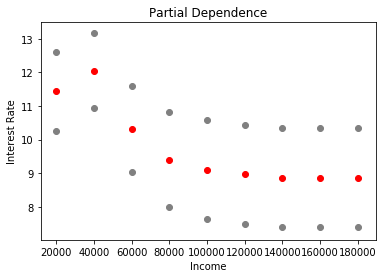

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt

examples = pd.concat([example, example2])
for income in range(20000, 200000, 20000):
    examples['Annual Income'] = income
    preds = gb.predict(examples)
    for pred in preds:
        plt.scatter(income, pred, color='grey')
    plt.scatter(income, np.mean(preds), color='red')
    plt.title('Partial Dependence')
    plt.xlabel('Income')
    plt.ylabel('Interest Rate')

## Partial Dependence Plots with 1 feature

#### PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_isolate](https://pdpbox.readthedocs.io/en/latest/pdp_isolate.html)
- [API Reference: pdp_plot](https://pdpbox.readthedocs.io/en/latest/pdp_plot.html)

In [15]:
# Later, when you save matplotlib images to include in blog posts or web apps,
# increase the dots per inch (double it), so the text isn't so fuzzy
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

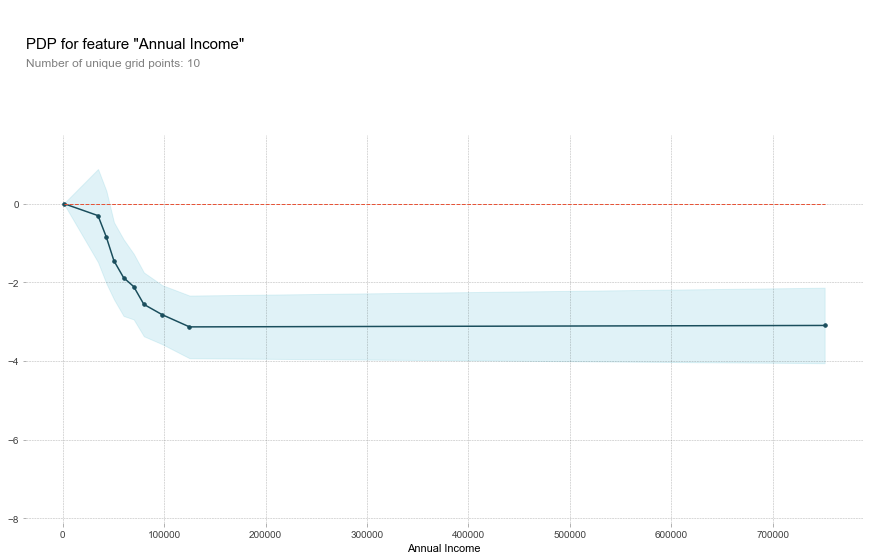

In [16]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'Annual Income'

isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature
)

pdp_plot(isolated, feature_name=feature);

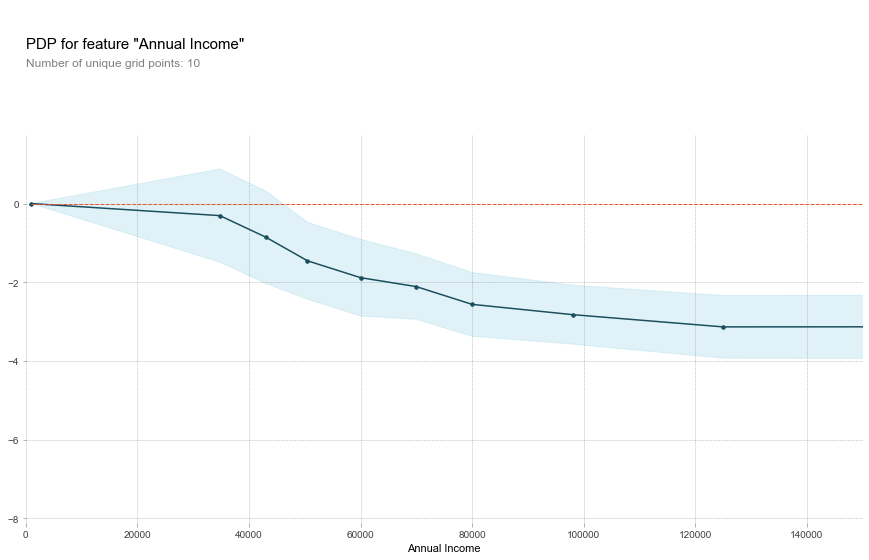

In [17]:
pdp_plot(isolated, feature_name=feature)
plt.xlim(0,150000);

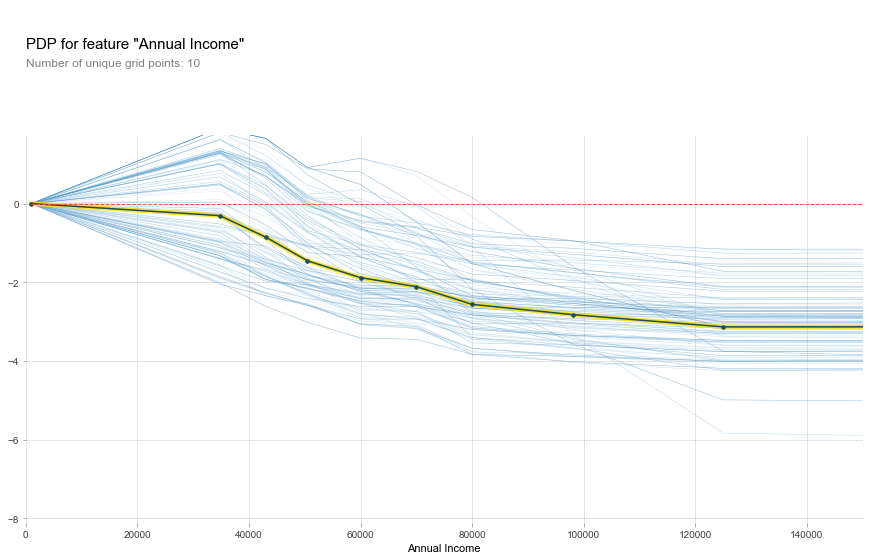

In [18]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,150000);

In [19]:
len(X_val) * 10

100000

In [20]:
isolated = pdp_isolate(
    model = gb,
    dataset = X_val,
    model_features=X_val.columns,
    feature=feature,
    num_grid_points=80
)

In [21]:
len(X_val) * 80

800000

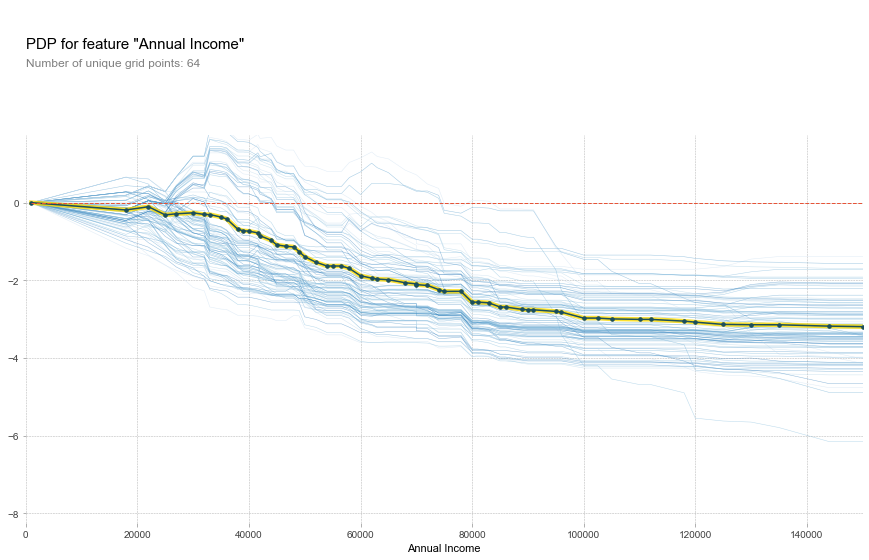

In [22]:
pdp_plot(isolated, feature_name=feature, plot_lines=True, frac_to_plot=100)
plt.xlim(0,150000);

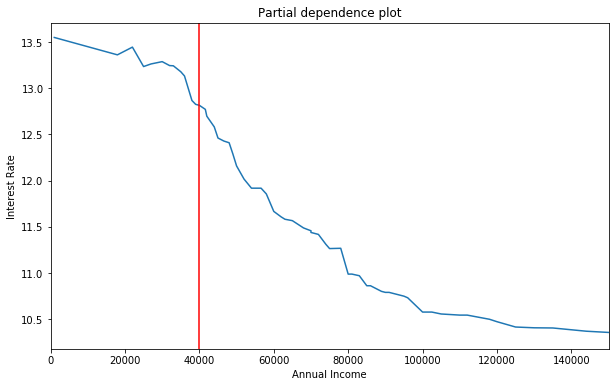

In [24]:
grid = isolated.feature_grids
pdp = isolated.pdp

plt.figure(figsize=(10,6))
plt.plot(grid, pdp)
plt.ylabel('Interest Rate')
plt.xlabel('Annual Income')
plt.title('Partial dependence plot')
plt.xlim(0,150000)
plt.axvline(40000,color='r')
plt.show();

In [25]:
ice = isolated.ice_lines.sample(n=100).T

ice

6012       7957       8005       4010       7182  \
1000.000000    15.510651  14.181878  13.098224  12.802619  10.990895   
17963.848101   15.914401  14.100809  12.471483  12.342649  10.804258   
22000.000000   15.717101  14.338455  12.424422  12.580296  11.041903   
25000.000000   15.274621  14.192373  12.068726  12.502542  10.969501   
27000.000000   15.017106  14.577778  11.705146  12.887947  11.097201   
30000.000000   14.965240  14.908545  11.328054  13.218714  11.154770   
32000.000000   14.965240  14.908545  11.240057  13.130717  11.066773   
33000.000000   14.855226  15.260572  10.782800  13.482745  10.798634   
35000.000000   14.802304  15.165668  10.687895  13.387840  10.703729   
36000.000000   14.806744  15.165668  10.676705  13.335991  10.618167   
38000.000000   14.677027  14.971399  10.435078  12.999249  10.272896   
39000.000000   14.677027  14.971399  10.327499  12.891670  10.272896   
40000.000000   14.677027  14.971399  10.327499  12.875243  10.256469   
41600.000000   14.629222  14.882910  10.279695  12.786754  10.167979   
42000.000000   14.614659  14.809104  10.256924  12.712948   9.986734   
44000.000000   14.466963  14.688742  10.209711  12.628123   9.890569   
45000.000000   14.466963  14.508901  10.169294  12.432213   9.611116   
46598.708861   14.388700  14.405702  10.169294  12.432213   9.611116   
48000.000000   14.388700  14.405702  10.169294  12.432213   9.509945   
49000.000000   14.300051  14.156984  10.061423  12.272145   9.440303   
50000.000000   14.300051  13.984380  10.061423  12.099541   9.228139   
52000.000000   14.274075  13.877087   9.996305  11.955113   9.083712   
54000.000000   14.279175  13.678715   9.886930  11.737471   8.950233   
55000.000000   14.279175  13.678715   9.886930  11.737471   8.950233   
56586.683544   14.279175  13.678715   9.886930  11.737471   8.950233   
58000.000000   14.254245  13.498775   9.862000  11.611779   8.884992   
60000.000000   14.107584  13.255797   9.570356  11.298830   8.620573   
62000.000000   14.107584  13.101894   9.537264  11.198521   8.520264   
63000.000000   14.107584  13.101894   9.537264  11.198521   8.520264   
65000.000000   14.139660  13.111425   9.569340  11.198521   8.520264   
...                  ...        ...        ...        ...        ...   
74000.000000   14.066516  12.811225   9.457976  10.821295   8.331434   
75000.000000   14.066516  12.811225   9.457976  10.821295   8.331434   
78000.000000   14.117215  12.811225   9.457976  10.821295   8.331434   
80000.000000   13.940843  12.503456   9.191408  10.357660   8.056026   
81000.000000   13.940843  12.503456   9.191408  10.357660   8.056026   
83000.000000   13.931877  12.478570   9.166522  10.332774   8.031140   
85000.000000   13.993965  12.364409   9.081523  10.218614   7.916980   
86000.000000   13.993965  12.364409   9.081523  10.218614   7.916980   
88946.835443   13.954682  12.256870   9.042240  10.179331   7.877696   
90000.000000   13.954682  12.236932   9.042240  10.159392   7.877696   
91000.000000   13.954682  12.236932   9.042240  10.159392   7.877696   
95000.000000   13.954682  12.236932   9.042240  10.159392   7.877696   
96000.000000   13.954682  12.236932   9.042240  10.159392   7.877696   
100000.000000  13.879839  12.084054   8.967397  10.006515   7.751458   
102494.556962  13.879839  12.084054   8.967397  10.006515   7.751458   
105000.000000  13.879839  12.039048   8.967397  10.006515   7.751458   
110000.000000  13.879839  12.039048   8.967397  10.006515   7.751458   
112000.000000  13.879839  12.039048   8.967397  10.006515   7.751458   
118000.000000  13.879839  11.996107   8.967397   9.963573   7.751458   
120000.000000  13.879839  11.953719   8.967397   9.921185   7.751458   
125000.000000  13.842053  11.871513   8.917722   9.838980   7.682876   
130000.000000  13.957567  11.844426   8.929617   9.811893   7.655789   
135000.000000  14.023358  11.833652   8.929617   9.801120   7.655789   
144000.000000  14.023358  11.805074   8.929617   9.772541   

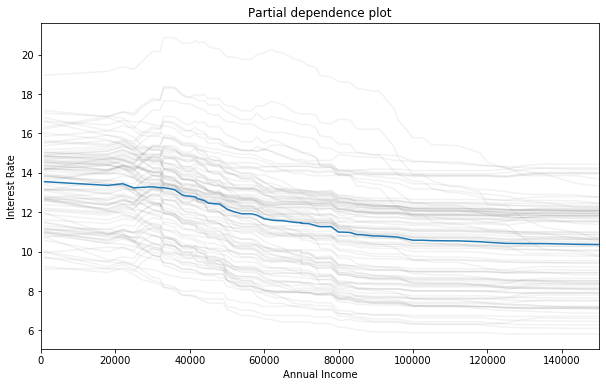

In [26]:
ice.plot(color='grey', alpha=0.1, legend=False, figsize=(10,6))

plt.plot(grid, pdp)
plt.ylabel('Interest Rate')
plt.xlabel('Annual Income')
plt.title('Partial dependence plot')
plt.xlim(0,150000);

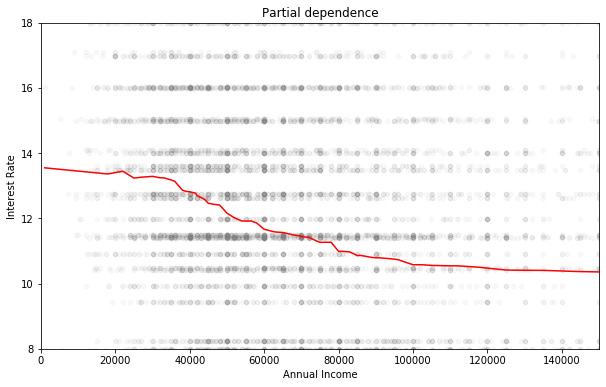

In [27]:
grid = isolated.feature_grids
pdp = isolated.pdp

val.plot.scatter(x='Annual Income', y='Interest Rate', 
                 color='grey', alpha=0.05, figsize=(10,6));

plt.plot(grid, pdp, color='r')
plt.xlim(0,150000)
plt.ylim(8,18)
plt.xlabel('Annual Income')
plt.ylabel('Interest Rate')
plt.title('Partial dependence');

#### You can customize it

PDPbox
- [API Reference: PDPIsolate](https://pdpbox.readthedocs.io/en/latest/PDPIsolate.html)

## Partial Dependence Plots with 2 features

See interactions!

PDPbox
- [Gallery](https://github.com/SauceCat/PDPbox#gallery)
- [API Reference: pdp_interact](https://pdpbox.readthedocs.io/en/latest/pdp_interact.html)
- [API Reference: pdp_interact_plot](https://pdpbox.readthedocs.io/en/latest/pdp_interact_plot.html)

Be aware of a bug in PDPBox version <= 0.20:
- With the `pdp_interact_plot` function, `plot_type='contour'` gets an error, but `plot_type='grid'` works
- This will be fixed in the next release of PDPbox: https://github.com/SauceCat/PDPbox/issues/40

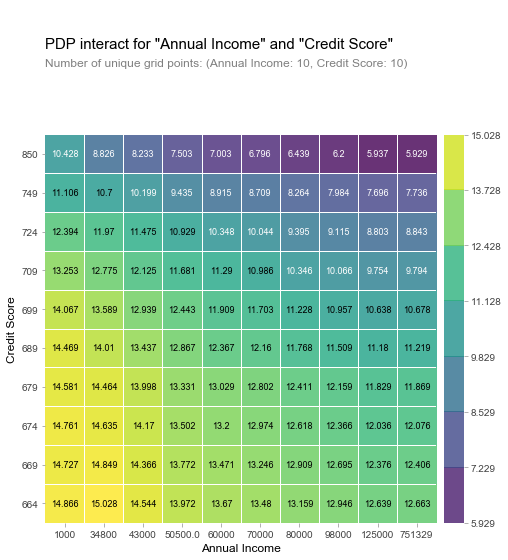

In [28]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['Annual Income', 'Credit Score']

interaction = pdp_interact(
  model=gb,
  dataset=X_val,
  model_features=X_val.columns,
  features=features 
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

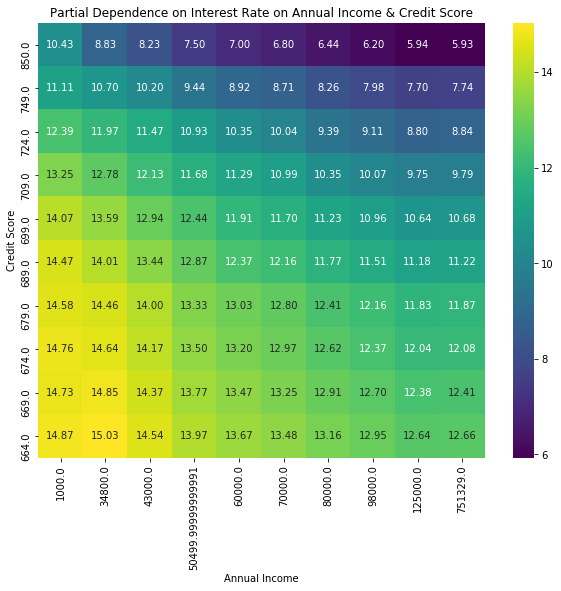

In [29]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], 
    index=features[1]
)[::-1] # Slice notation to reverse index order so y axis is ascending

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence on Interest Rate on Annual Income & Credit Score');

### 3D with Plotly!

In [30]:
import plotly.graph_objs as go

surface = go.Surface(x=pdp.columns, 
                     y=pdp.index, 
                     z=pdp.values)

fig = go.Figure(surface)
fig.show()

In [31]:
pdp.columns

Float64Index([           1000.0,           34800.0,           43000.0,
              50499.99999999991,           60000.0,           70000.0,
                        80000.0,           98000.0,          125000.0,
                       751329.0],
             dtype='float64', name='Annual Income')

In [32]:
pdp = pdp.drop(columns=751329.0)

In [33]:
surface = go.Surface(x=pdp.columns, 
                     y=pdp.index, 
                     z=pdp.values)


layout = go.Layout(
    scene=dict(
        xaxis=dict(title=features[0]), 
        yaxis=dict(title=features[1]), 
        zaxis=dict(title=target)
    )
)

fig = go.Figure(surface, layout)
fig.show()

# Partial Dependence Plots with categorical features

1. I recommend you use Ordinal Encoder, outside of a pipeline, to encode your data first. (If there is a natural ordering, then take the time to encode it that way, instead of random integers.) Then use the encoded data with pdpbox.
2. There's some extra work to get readable category names on your plot, instead of integer category codes.

In [34]:
# Fit a model on Titanic data
import category_encoders as ce
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

df = sns.load_dataset('titanic')
df.age = df.age.fillna(df.age.median())
df = df.drop(columns='deck')
df = df.dropna()

target = 'survived'
features = df.columns.drop(['survived', 'alive'])

X = df[features]
y = df[target]

# Use Ordinal 
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

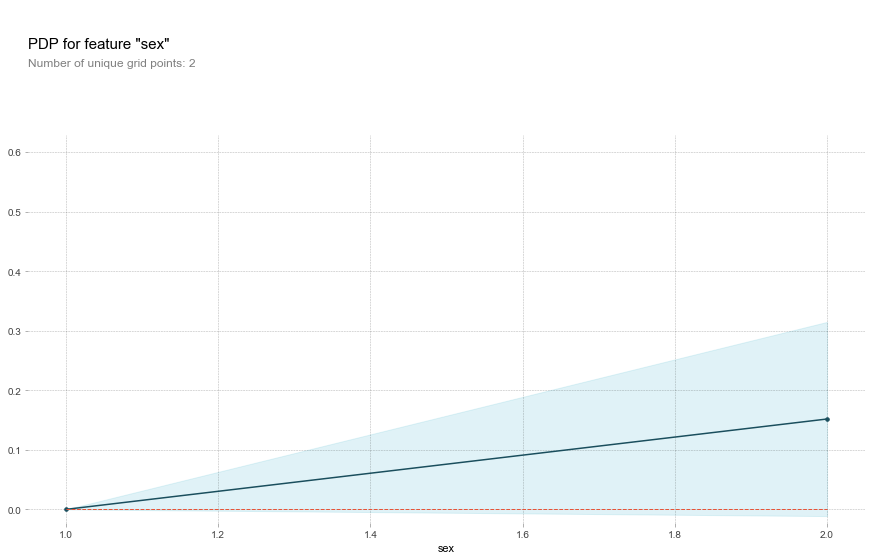

In [35]:
# Use Pdpbox
%matplotlib inline
import matplotlib.pyplot as plt
from pdpbox import pdp
feature = 'sex'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_encoded, model_features=features, feature=feature)
pdp.pdp_plot(pdp_dist, feature);

In [36]:
# Look at the encoder's mappings
encoder.mapping

[{'col': 'sex', 'mapping': male      1
  female    2
  NaN      -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embarked', 'mapping': S      1
  C      2
  Q      3
  NaN   -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'class', 'mapping': First     1
  Second    2
  Third     3
  NaN      -2
  dtype: int64, 'data_type': CategoricalDtype(categories=['First', 'Second', 'Third'], ordered=False)},
 {'col': 'who', 'mapping': man      1
  woman    2
  child    3
  NaN     -2
  dtype: int64, 'data_type': dtype('O')},
 {'col': 'embark_town', 'mapping': Southampton    1
  Cherbourg      2
  Queenstown     3
  NaN           -2
  dtype: int64, 'data_type': dtype('O')}]

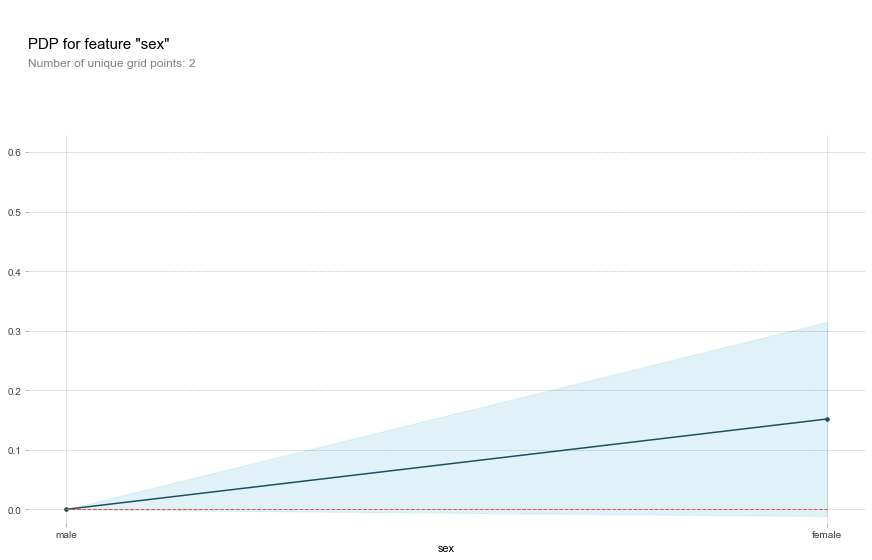

In [37]:
pdp.pdp_plot(pdp_dist, feature)

# Manually change the xticks labels
plt.xticks([1, 2], ['male', 'female']);

In [38]:
# Let's automate it

feature = 'sex'
for item in encoder.mapping:
    if item['col'] == feature:
        feature_mapping = item['mapping']

feature_mapping = feature_mapping[feature_mapping.index.dropna()]
category_names = feature_mapping.index.tolist()
category_codes = feature_mapping.values.tolist()

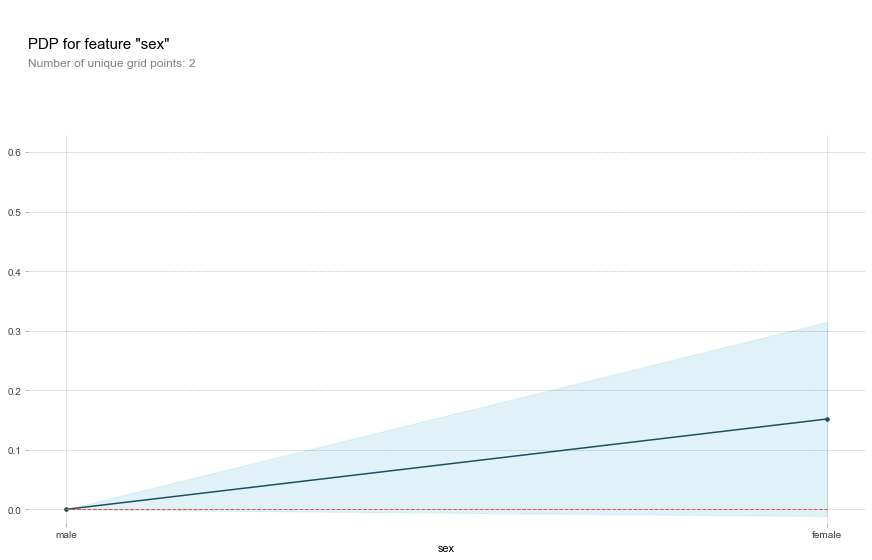

In [39]:
pdp.pdp_plot(pdp_dist, feature)

# Automatically change the xticks labels
plt.xticks(category_codes, category_names);

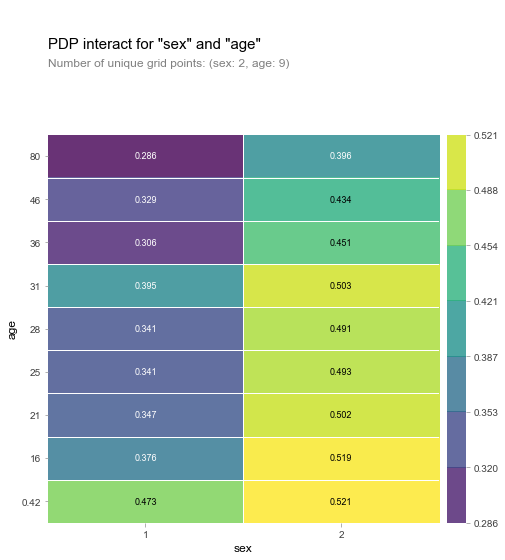

In [40]:
features = ['sex', 'age']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);

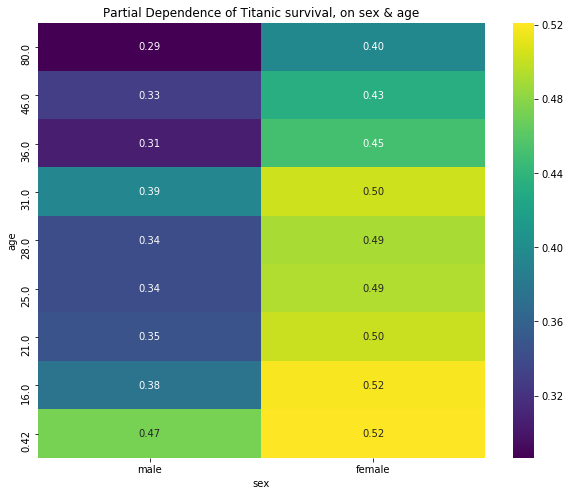

In [41]:
pdp = interaction.pdp.pivot_table(
    values='preds', 
    columns=features[0], # First feature on x axis
    index=features[1]    # Next feature on y axis
)[::-1]  # Reverse the index order so y axis is ascending

pdp = pdp.rename(columns=dict(zip(category_codes, category_names)))

plt.figure(figsize=(10,8))
sns.heatmap(pdp, annot=True, fmt='.2f', cmap='viridis')
plt.title('Partial Dependence of Titanic survival, on sex & age');